In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import json

In [7]:
# Load all the data for a specific scenario
application = "hotel_reservation"
scenarios = ["browse", "reserve"]

# setups = [(name, color, tick_type, label)]
setups = [
    ("gcr", "g", "--", "GCR", "final_test_lower_payload"),
    ("gke_standard", "r", "--", "GKE Standard", "final_test_lower_payload"),
    ("gke_autopilot", "b", "--", "GKE Autopilot", "final_test_lower_payload"),
]
loads = [2, 4, 5, 6]



data = {}
for scenario in scenarios:
    data[scenario] = {}
    for load in loads:
        data[scenario][load] = {}
        for infra, _, _, _, run_id in setups:
            if infra not in data[scenario][load]:
                data[scenario][load][infra] = {}
            path = f"../results/{application}/{scenario}/{infra}/{run_id}/{load}"
            data_tmp = {}

            with open(f"{path}/gcp_metrics.json", "r") as f:
                data_tmp["gcp_metrics"] = json.load(f)
            with open(f"{path}/summary.json", "r") as f:
                data_tmp["summary"] = json.load(f)
            with open(f"{path}/hotels/statistics.json", "r") as f:
                data_tmp["statistics"] = json.load(f)
            
            data_tmp["percentiles"] = pd.read_csv(f"{path}/hotels/percentiles.csv")
            data_tmp["nr_requests"] = pd.read_csv(f"{path}/hotels/nr_requests.csv")
            data[scenario][load][infra][run_id] = data_tmp


In [3]:
def p(filename, loads, scenario):

    size_factor = 2

    SMALL_SIZE = 18
    MEDIUM_SIZE = 27
    plt.rc('font', size=MEDIUM_SIZE)
    plt.rc('axes', labelsize=MEDIUM_SIZE)
    plt.rc('xtick', labelsize=MEDIUM_SIZE)
    plt.rc('ytick', labelsize=19)
    plt.rc('legend', fontsize=MEDIUM_SIZE)
    plt.rc('figure', titlesize=MEDIUM_SIZE)

    fig, axs = plt.subplots(
        nrows=3,
        ncols=len(loads),
        figsize=(20 * size_factor, 14 * size_factor),
        gridspec_kw={"height_ratios": [2, 4, 5]},
    )

    for i, load in enumerate(loads):
        # Draw the top plot
        setup_id = 0
        infra = setups[setup_id][0]
        run_id = setups[setup_id][4]
        nr_req = data[scenario][load][infra][run_id]["nr_requests"]
        # print(nr_req)
        nr_req["mov_avg"] = nr_req["counts"].rolling(2).mean()

        axs[0][i].plot(nr_req["mov_avg"], "--m", label="avg", linewidth=1.0)
        axs[0][i].set_xlim(xmax=600)

        # Draw the middle plot
        for setup_nr, (infra, color, tick, label, run_id) in enumerate(setups):
            data_tmp = data[scenario][load][infra][run_id]["percentiles"]
            fill_between = ("p30", "p70")

            axs[1][i].plot(data_tmp["p50"], f"{tick}{color}", label=label, linewidth=1.5)
            axs[1][i].fill_between(data_tmp["sec_since_start"], data_tmp[fill_between[0]], data_tmp[fill_between[1]], alpha=0.075, color=f"{color}")
            axs[1][i].plot(data_tmp[fill_between[0]], f"{':'}{color}", linewidth=0.5, alpha=0.9)
            axs[1][i].plot(data_tmp[fill_between[1]], f"{':'}{color}", linewidth=0.5, alpha=0.9)
            axs[1][i].set_xlim(xmax=600)


        # The load-pattern in the middle plot
        new_axs = axs[1][i].twinx()
        new_axs.set_ylim(ymin=0, ymax=nr_req["mov_avg"].max())
        new_axs.fill_between(nr_req.index, nr_req["mov_avg"], alpha=0.075, color="k")
        new_axs.set_yticks([])

        # Draw the lowest plot
        labels = ["P50", "P90", "P95", "Avg"]
        hatches = ['oo', '////', '..', 'xxx']
        x = np.arange(len(labels))
        width = 0.8 / len(setups)
        m = 0
        for j, (infra, color, tick, label, run_id) in enumerate(setups):
            statistics = data[scenario][load][infra][run_id]["statistics"]
            metrics = [
                round(statistics["p50"], 0),
                round(statistics["p90"], 0),
                round(statistics["p95"], 0),
                round(statistics["avg"], 0),
            ]
            bar = axs[2][i].bar(x - width + width * j, metrics, width, label=label, color=color, alpha=0.25)
            axs[2][i].bar_label(bar, padding=1.5)
            m = max(m, statistics["p95"])

        # Add labels, legends etc.
        axs[0][i].set(ylabel="# of Requests/s", xlabel="Time (s)")
        axs[1][i].set(ylabel="Response time (ms)", xlabel="Time (s)")
        handles, _ = axs[1][i].get_legend_handles_labels()
        handles.append(Patch(color="k", alpha=0.075, label="Load (without scale)"))
        axs[1][i].legend(handles=handles)
        
        axs[2][i].set(ylabel="Number of pods")

        axs[2][i].set(ylabel="Response time (ms)")
        axs[2][i].set_xticks(x, labels)
        axs[2][i].legend()
        axs[2][i].set_ylim(ymax=m * 1.3)
        for j in range(2):
            axs[j][i].set_xlim(xmin=0)
            axs[j][i].set_ylim(ymin=0)
            axs[j][i].grid(axis="both", color="0.9", linestyle="-", linewidth=1)

    fig.savefig(filename, bbox_inches='tight')


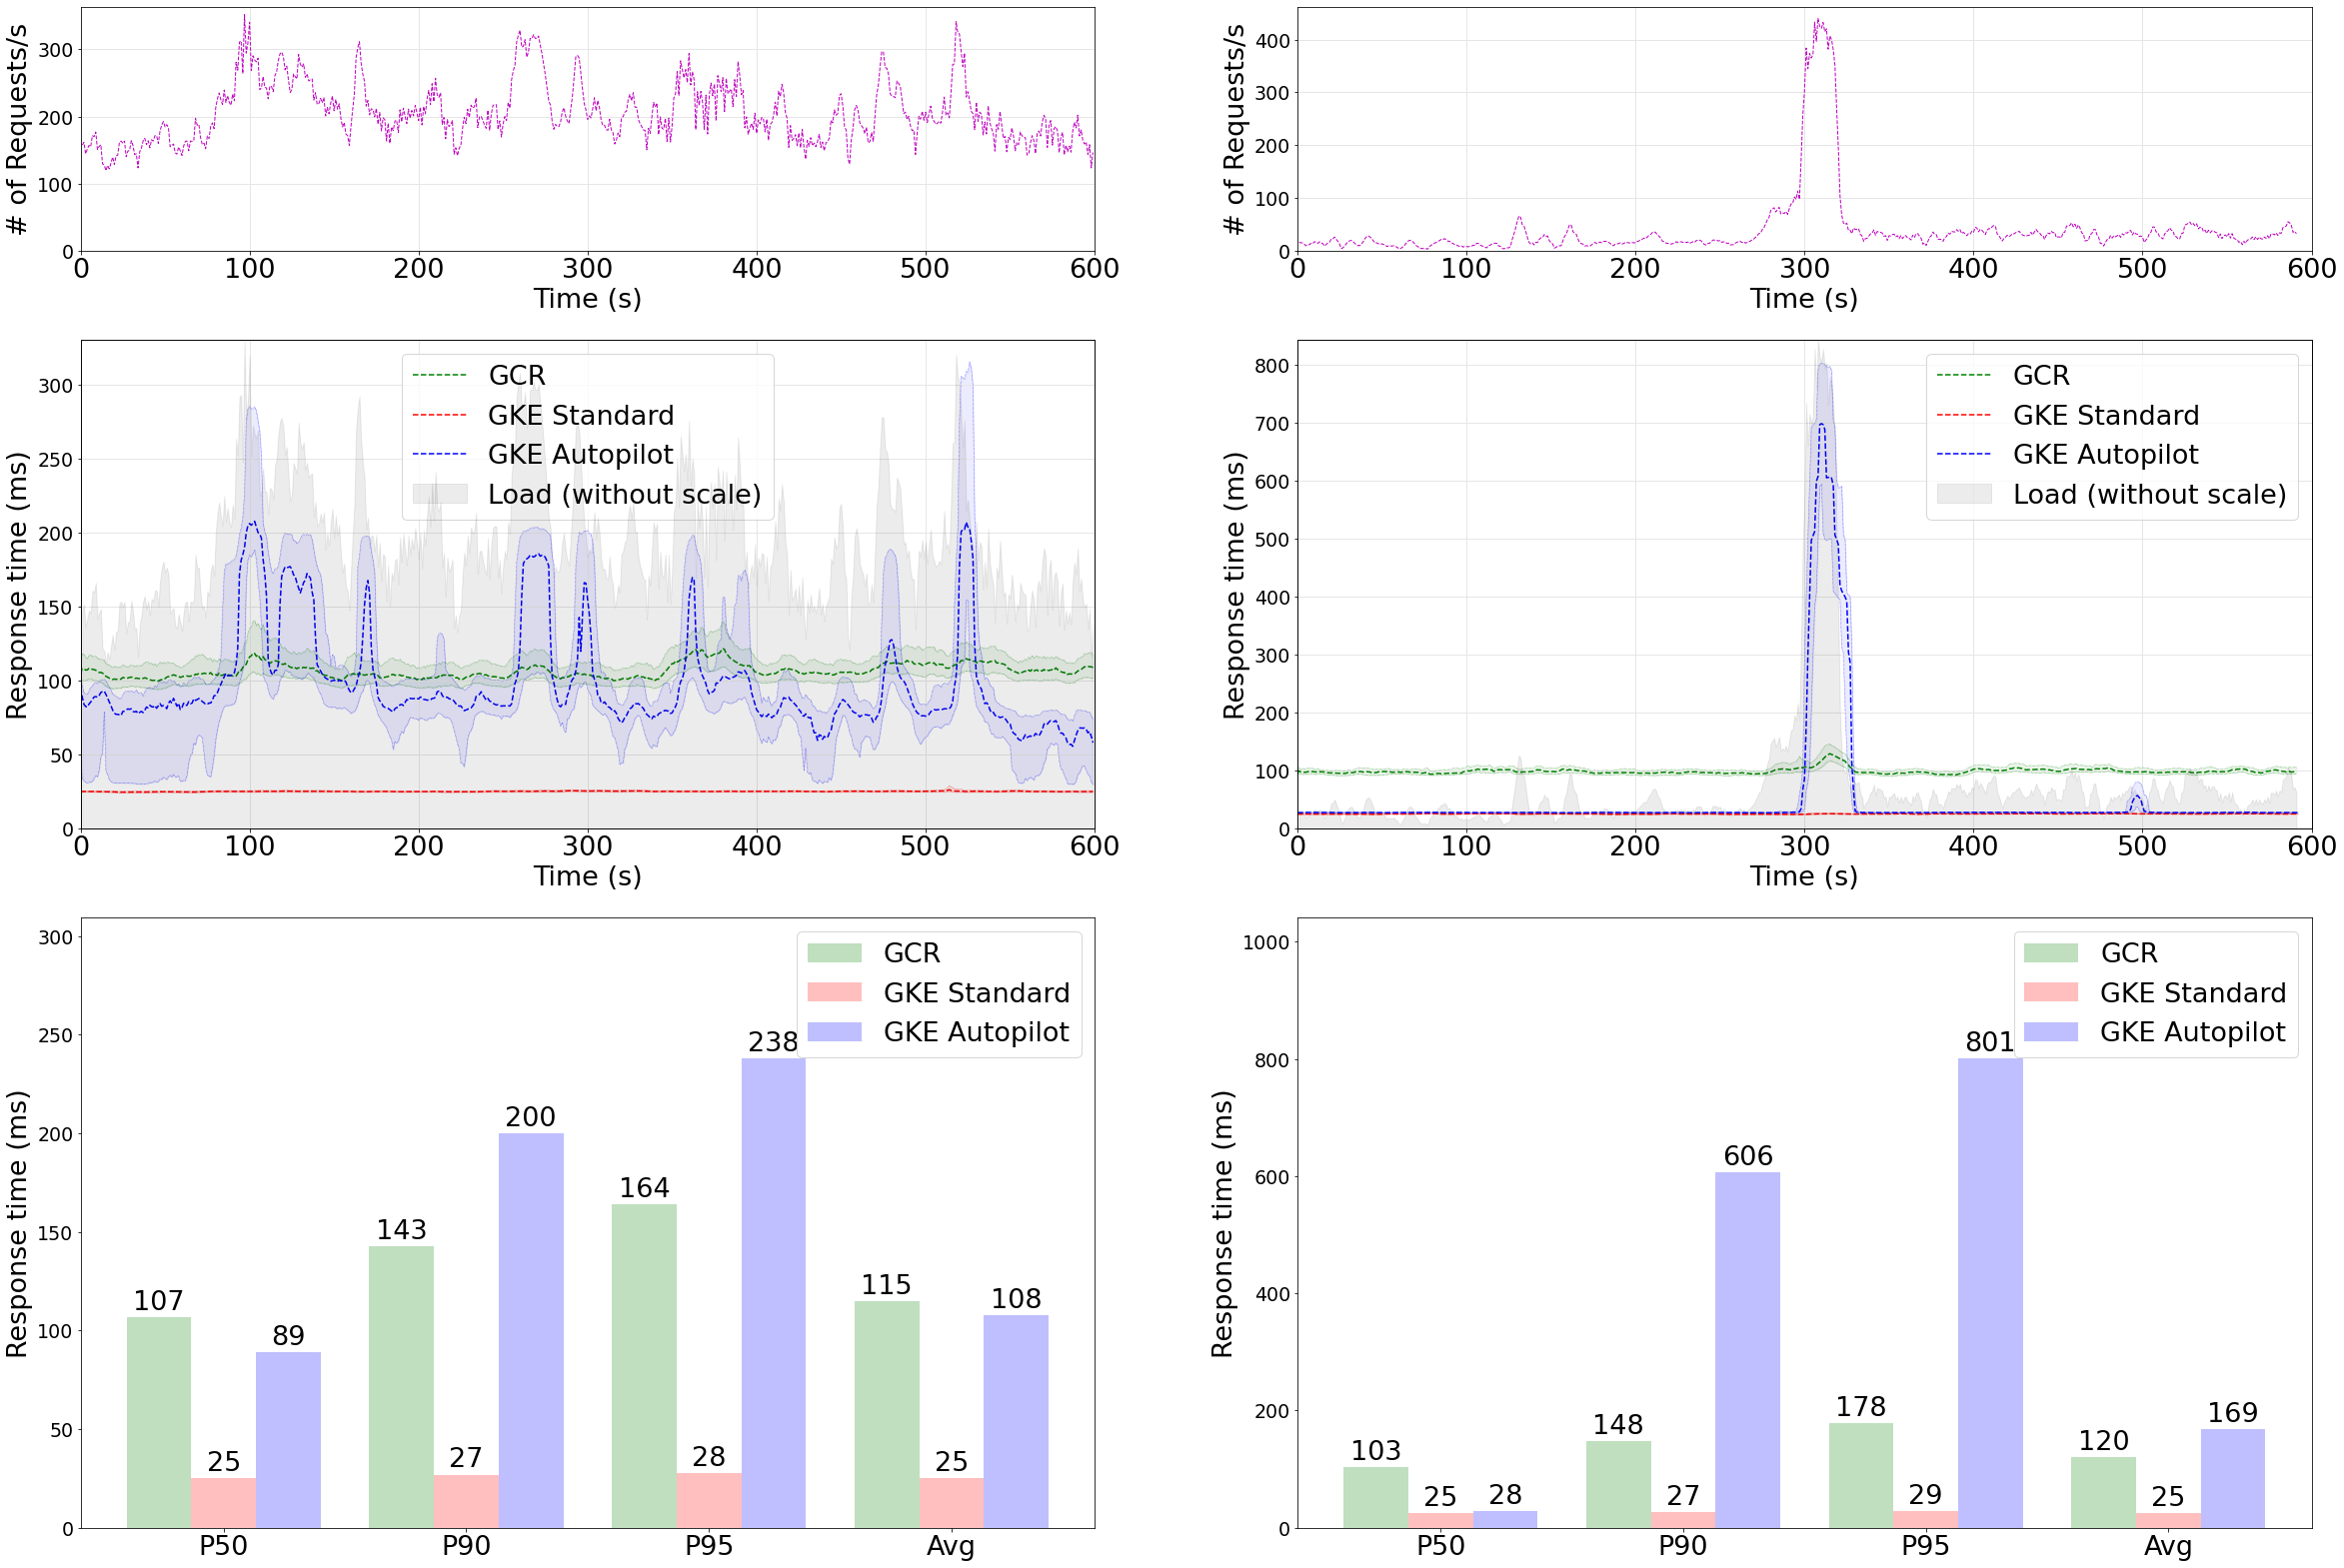

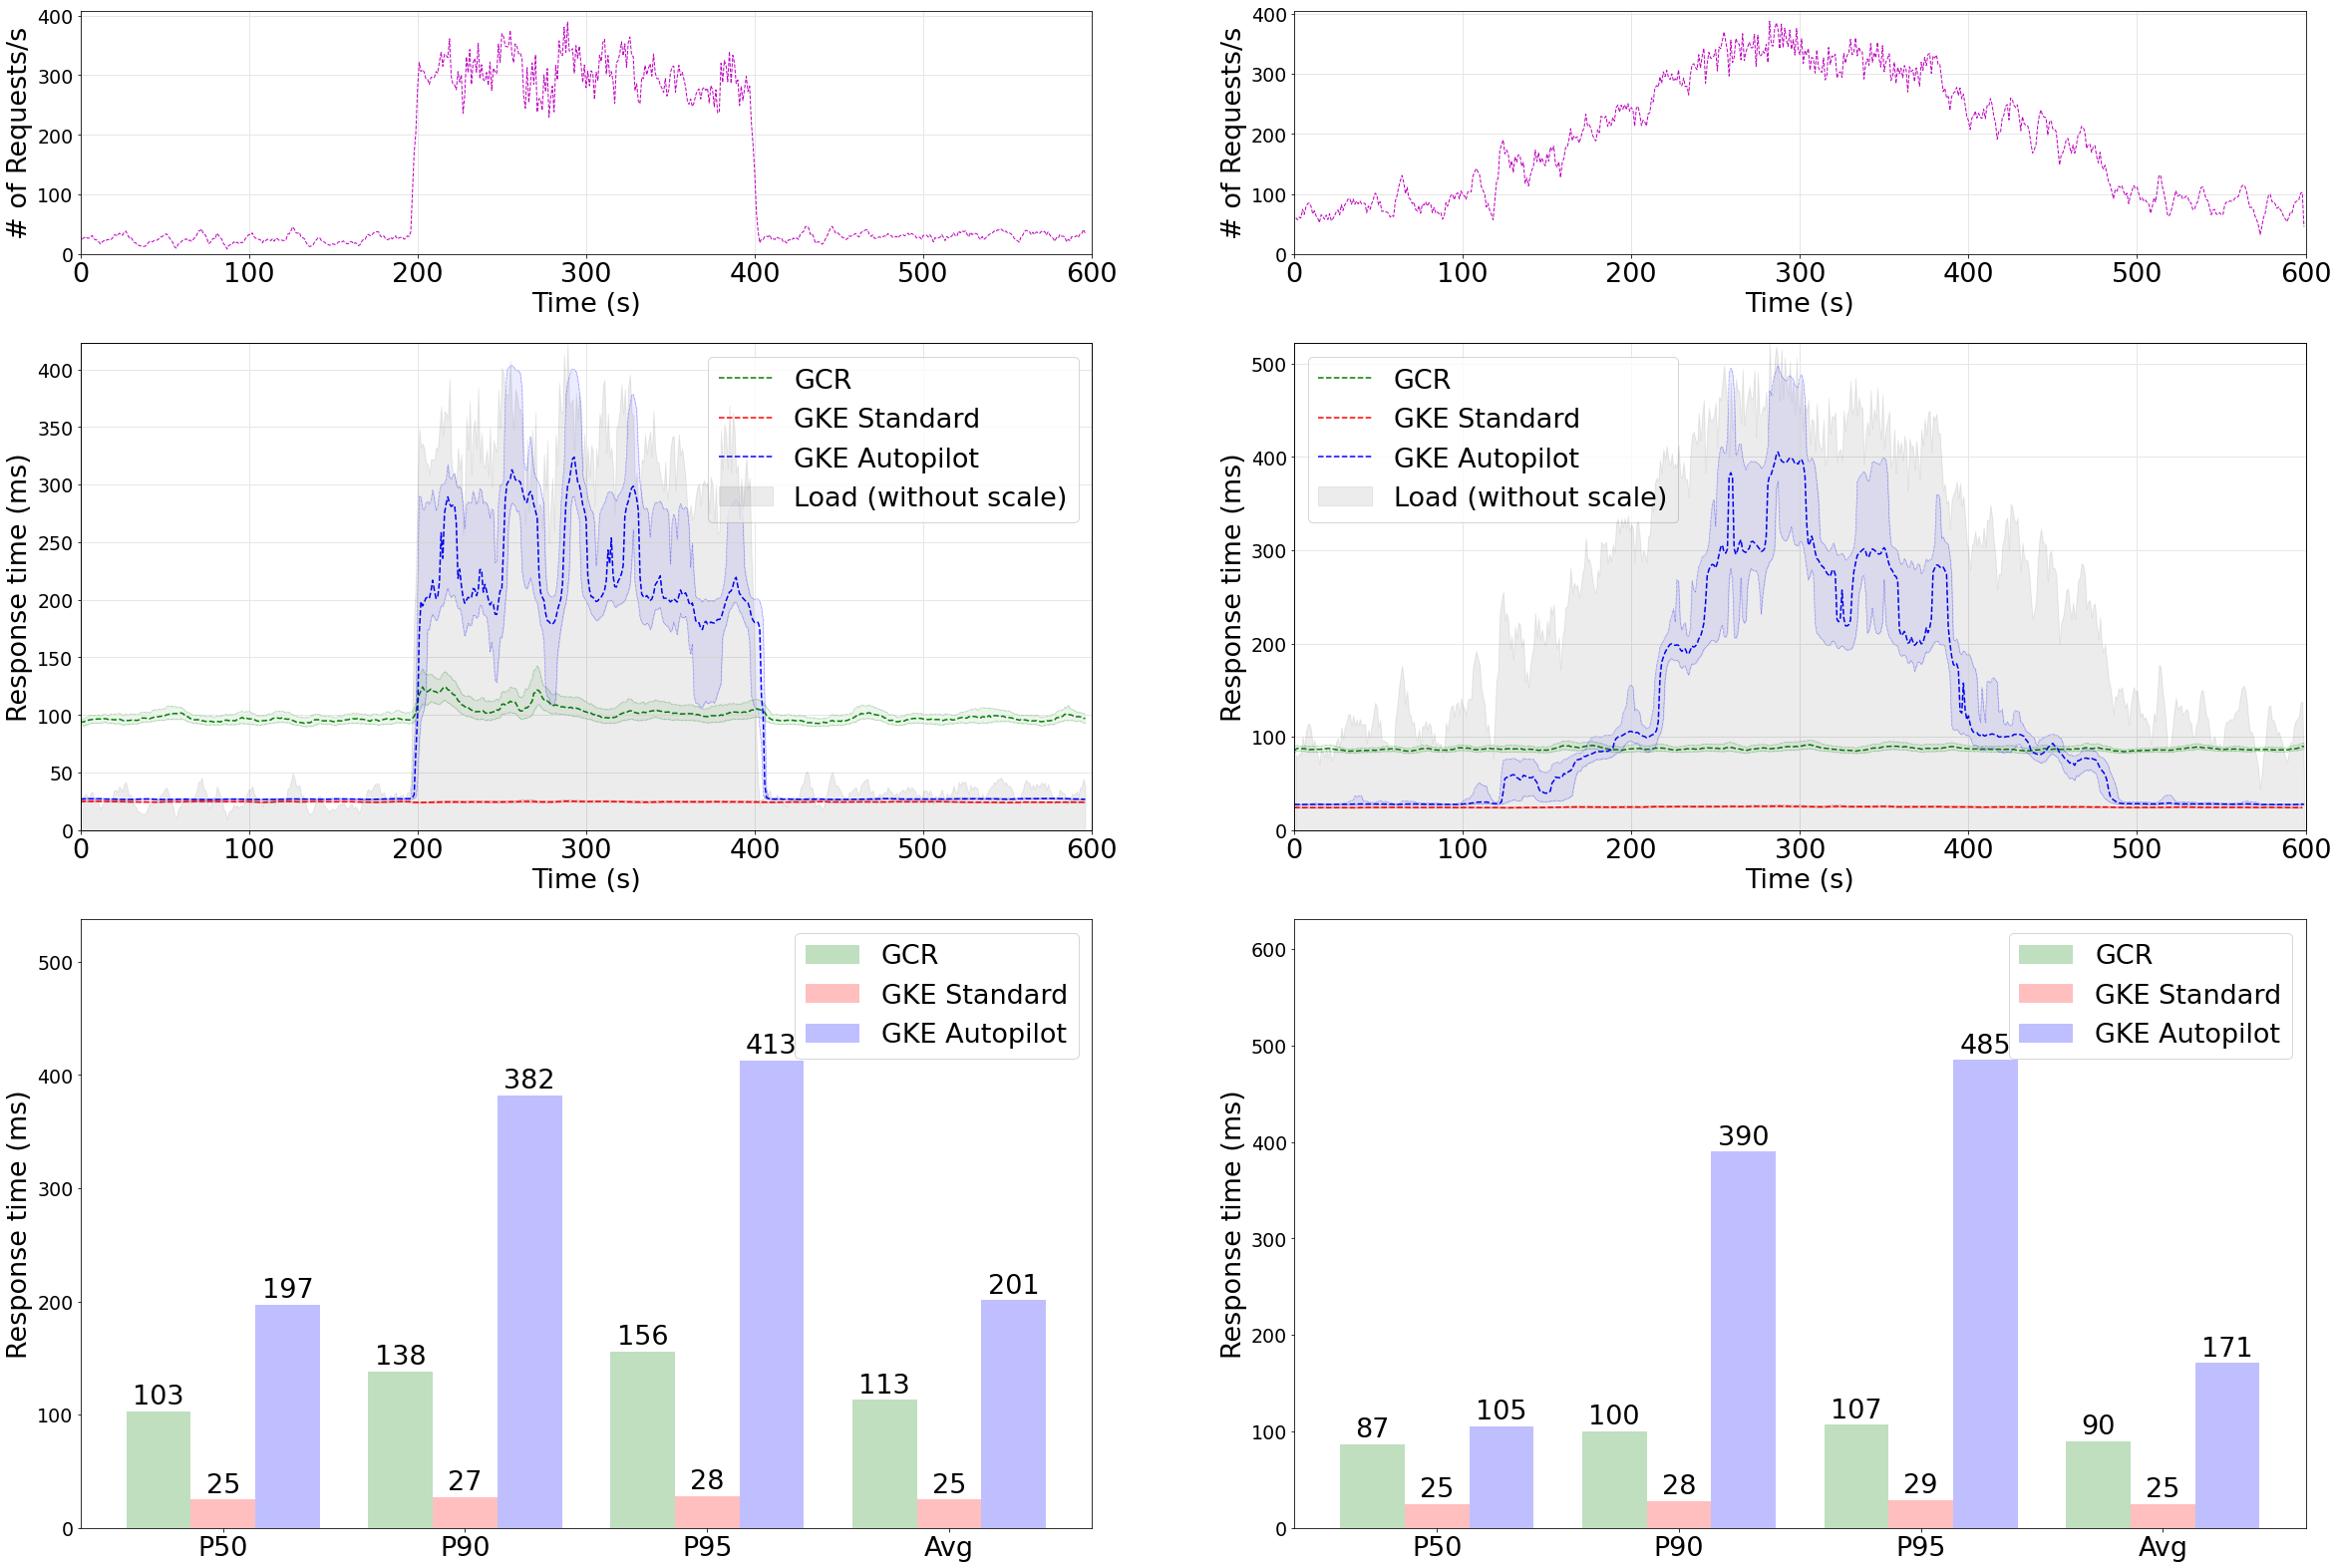

In [8]:
p("latency_hr_browse_2_4.pdf", [2,4], "browse")
p("latency_hr_browse_5_6.pdf", [5,6], "browse")